<a href="https://colab.research.google.com/github/z26qin/ML-Prediction/blob/main/LSTM_on_TSLA_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
# Import finance API and get historical stock data
%%time
import yfinance as yf
import os
import json
import pandas as pd
import datetime
DATA_PATH = "tsla_data.json"

if os.path.exists(DATA_PATH):
    # Read from file if we've already downloaded the data.
    with open(DATA_PATH) as f:
        tsla_hist = pd.read_json(DATA_PATH)
else:
    tsla = yf.Ticker("TSLA")
    tsla_hist = tsla.history(period="max")

    # Save file to json in case we need it later.  This prevents us from having to re-download it every time.
    tsla_hist.to_json(DATA_PATH)
tsla_hist
# Display microsoft stock price history so we can look at the structure of the data

CPU times: user 148 ms, sys: 4.04 ms, total: 152 ms
Wall time: 360 ms


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2010-06-29 00:00:00-04:00,1.266667,1.666667,1.169333,1.592667,281494500,0.0,0.0
2010-06-30 00:00:00-04:00,1.719333,2.028000,1.553333,1.588667,257806500,0.0,0.0
2010-07-01 00:00:00-04:00,1.666667,1.728000,1.351333,1.464000,123282000,0.0,0.0
2010-07-02 00:00:00-04:00,1.533333,1.540000,1.247333,1.280000,77097000,0.0,0.0
2010-07-06 00:00:00-04:00,1.333333,1.333333,1.055333,1.074000,103003500,0.0,0.0
...,...,...,...,...,...,...,...
2024-01-26 00:00:00-05:00,185.500000,186.779999,182.100006,183.250000,107063400,0.0,0.0
2024-01-29 00:00:00-05:00,185.630005,191.479996,183.669998,190.929993,125013100,0.0,0.0
2024-01-30 00:00:00-05:00,195.330002,196.360001,190.610001,191.589996,109982300,0.0,0.0


In [29]:
import datetime

def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

In [30]:
df = tsla_hist


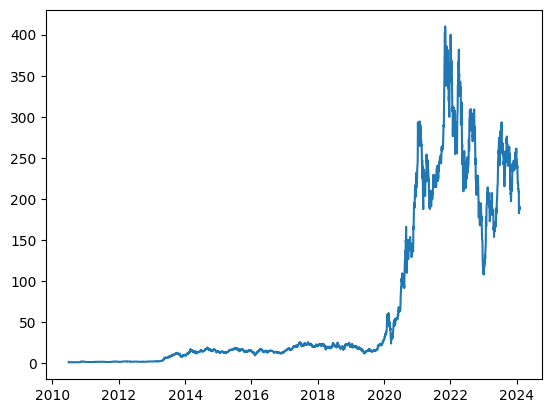

In [31]:
import matplotlib.pyplot as plt

plt.plot(df.index, df['Close'])

In [32]:
import numpy as np

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date

  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)

    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))

    if last_time:
      break

    target_date = next_date

    if target_date == last_date:
      last_time = True

  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates

  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]

  ret_df['Target'] = Y

  return ret_df

# Start day second time around: '2021-03-25'
windowed_df = df_to_windowed_df(df,
                                '2021-03-25',
                                '2022-03-23',
                                n=3)
windowed_df

<ipython-input-32-affb821c645e>:14: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  df_subset = dataframe.loc[:target_date].tail(n+1)
<ipython-input-32-affb821c645e>:27: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]


,Target Date,Target-3,Target-2,Target-1,Target
0,2021-03-25,223.333328,220.720001,210.089996,213.463333
1,2021-03-26,220.720001,210.089996,213.463333,206.236664
2,2021-03-29,210.089996,213.463333,206.236664,203.763336
3,2021-03-30,213.463333,206.236664,203.763336,211.873337
4,2021-03-31,206.236664,203.763336,211.873337,222.643326
...,...,...,...,...,...
247,2022-03-17,255.456665,267.296661,280.076660,290.533325
248,2022-03-18,267.296661,280.076660,290.533325,301.796661
249,2022-03-21,280.076660,290.533325,301.796661,307.053345
250,2022-03-22,290.533325,301.796661,307.053345,331.326660


In [33]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((252,), (252, 3, 1), (252,))

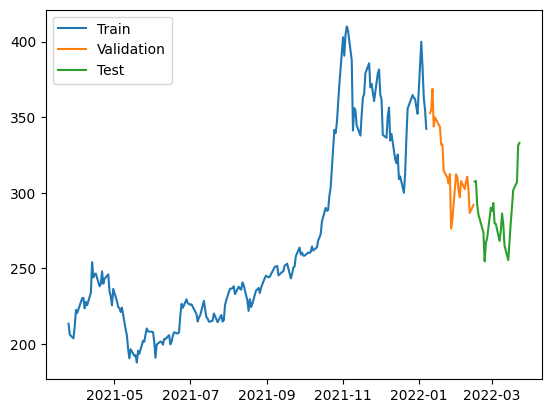

In [34]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
7/7 [==============================] - 3s 98ms/step - loss: 73599.2656 - mean_absolute_error: 264.4741 - val_loss: 100619.0703 - val_mean_absolute_error: 316.3024
Epoch 2/100
7/7 [==============================] - 0s 9ms/step - loss: 73336.9531 - mean_absolute_error: 263.9764 - val_loss: 100344.4297 - val_mean_absolute_error: 315.8677
Epoch 3/100
7/7 [==============================] - 0s 12ms/step - loss: 73092.6250 - mean_absolute_error: 263.5071 - val_loss: 100016.7422 - val_mean_absolute_error: 315.3485
Epoch 4/100
7/7 [==============================] - 0s 13ms/step - loss: 72815.7891 - mean_absolute_error: 262.9843 - val_loss: 99655.7891 - val_mean_absolute_error: 314.7759
Epoch 5/100
7/7 [==============================] - 0s 16ms/step - loss: 72491.3203 - mean_absolute_error: 262.3713 - val_loss: 99238.6328 - val_mean_absolute_error: 314.1125
Epoch 6/100
7/7 [==============================] - 0s 16ms/step - loss: 72104.1328 - mean_absolute_error: 261.6202 - val_loss: 9

7/7 [==============================] - 0s 4ms/step


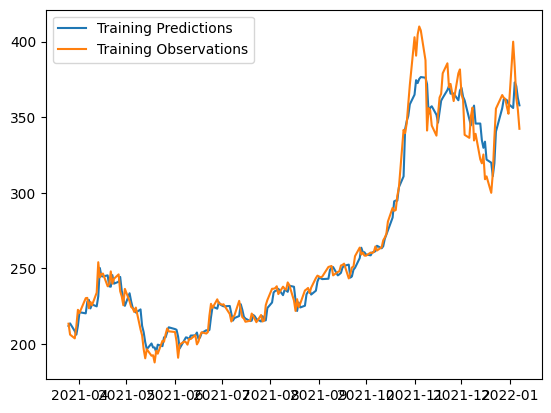

In [36]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

1/1 [==============================] - 0s 21ms/step


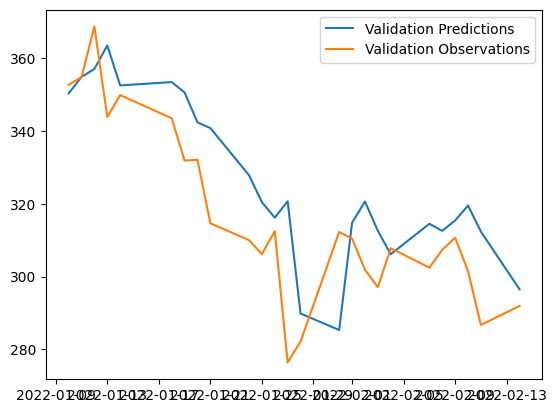

In [37]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

1/1 [==============================] - 0s 20ms/step


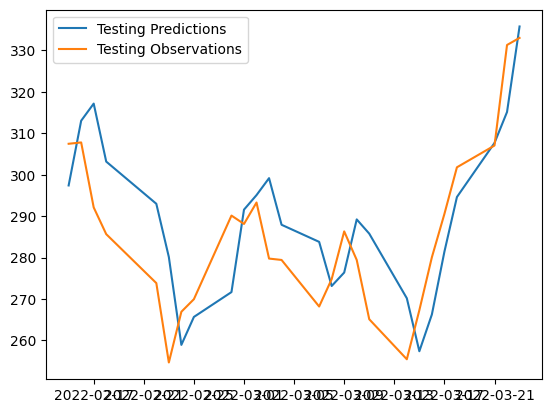

In [38]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

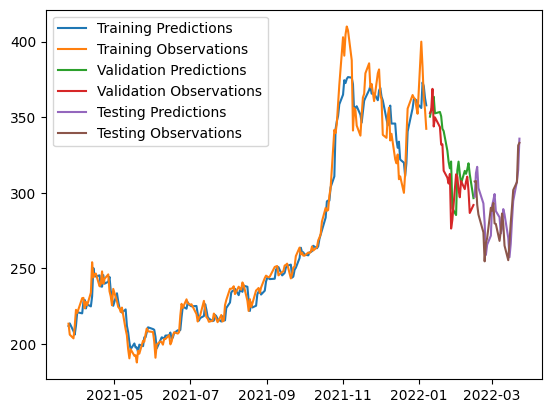

In [39]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations'])

In [40]:
from copy import deepcopy

recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])

for target_date in recursive_dates:
  last_window = deepcopy(X_train[-1])
  next_prediction = model.predict(np.array([last_window])).flatten()
  recursive_predictions.append(next_prediction)
  last_window[-1] = next_prediction

1/1 [==============================] - 0s 23ms/step


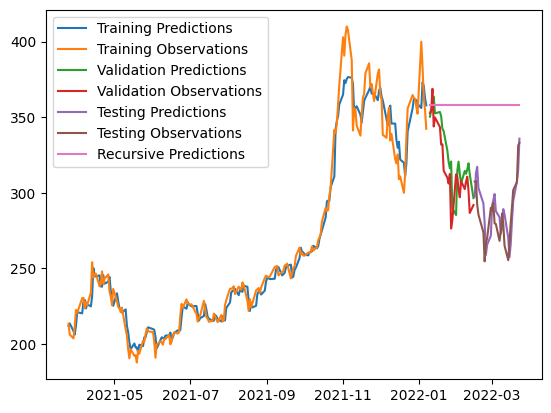

In [41]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations',
            'Recursive Predictions'])